In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import yfinance as yf

Text(0.5, 1.0, 'Geometric Brownian Motion')

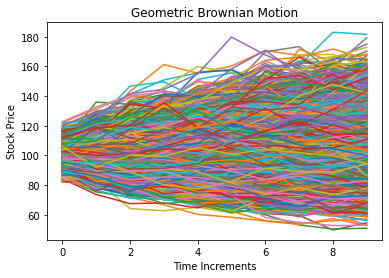

In [36]:
def geo_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=(steps,N))),axis=0)
    
    return np.exp(ST)

S = 100 #stock price S_{0}
K = 110 # strike
T = 1/2 # time to maturity
r = 0.05 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.25 # annual volatility in %
steps = 10 # time steps
N = 10000 # number of trials

paths= geo_paths(S,T,r, q,sigma,steps,N)

plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

In [37]:
def black_scholes_call(S,K,T,r,q,sigma):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
    d2 = d1 - sigma* np.sqrt(T)
    
    call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    return call



payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value

bs_price = black_scholes_call(S,K,T,r,q,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

Black Scholes Price is 3.7451887662410783
Simulated price is 3.7348982298513365


In [38]:
def binomial_european_call(S, K, T, r, q, sigma, N):
    """ 
    This function prices European call options using the binomial model.
    Input parameters:
    S : float : initial stock price
    K : float : strike price
    T : float : time to expiration (in years)
    r : float : risk-free interest rate
    sigma : float : volatility
    N : int : number of time steps
    Output:
    float : option price
    """
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp((r -q) * dt) - d) / (u - d)

    # Download the historical data of the stock
    symbol = "AAPL"
    start_date = "2019-01-01"
    end_date = "2022-01-01"
    stock_data = yf.download(symbol, start=start_date, end=end_date)

    # Calculate the daily returns of the stock
    stock_data["Returns"] = stock_data["Adj Close"].pct_change()

    # Calculate the daily volatility of the stock
    daily_volatility = stock_data["Returns"].std()

    # Annualize the volatility
    annual_volatility = daily_volatility * math.sqrt(252)

    # Calculate the expected return of the stock
    expected_return = stock_data["Returns"].mean()

    # Calculate the risk-free rate
    risk_free_rate = 0.02

    # Adjust the parameters for the binomial model
    u = math.exp((expected_return - 0.5 * annual_volatility ** 2) * dt + annual_volatility * math.sqrt(dt))
    d = math.exp((expected_return - 0.5 * annual_volatility ** 2) * dt - annual_volatility * math.sqrt(dt))
    p = (math.exp(risk_free_rate * dt) - d) / (u - d)

    # Calculate the stock prices at each node
    stock_prices = []
    for i in range(N+1):
        stock_prices.append(S * u**(N-i) * d**(i))

    # Calculate the option prices at expiration
    option_values = [max(0, stock_prices[i] - K) for i in range(N+1)]

    # Calculate the option prices at earlier time steps
    for n in range(N-1, -1, -1):
        for i in range(n+1):
            option_values[i] = math.exp(-risk_free_rate*dt) * (p * option_values[i] + (1-p) * option_values[i+1])

    return option_values[0]

In [39]:
bi_price = binomial_european_call(S,K,T,r,q,sigma,steps)

[*********************100%***********************]  1 of 1 completed


In [40]:
print(bi_price)

6.222367546230783
